In [1]:
import os
cwd = os.getcwd()

In [2]:
cd {cwd}

/mnt/File/shamgholi/projects/person_reid/AP3D


# load model

In [11]:
import sys
import os
sys.path.append(cwd)
import time
import math
import os.path as osp
import numpy as np

import torch
from torch.utils.data import DataLoader

from config import Config
import models
import transforms.spatial_transforms as ST
import transforms.temporal_transforms as TT
import tools.data_manager as data_manager
from tools.video_loader import VideoDataset
from tools.utils import Logger
# from tools.eval_metrics import evaluate
from commons import modify_model
from tqdm import tqdm
import random


def seed_everythings():
    seed = 1
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)



class Args:
    #"/home/hadi/iust/datasets"
    #"/home/shamgholi/iust/datasets" 
    #"/mnt/File/shamgholi/datasets"
    root = "/mnt/File/shamgholi/datasets"
    dataset = "mars"
    workers = 0
    height = 256
    width = 128
    # test_frames = 8
    arch = "ap3dres50"
    resume = "./"
    pretrain = os.path.join(cwd, "logs/row41/best_model.pth.tar")
    test_epochs = [240]
    distance = "cosine" #cosine
    gpu = "0"
    test_batch = 6
    

In [12]:
from __future__ import print_function, absolute_import
import numpy as np
import copy


def compute_ap_cmc(index, good_index, junk_index):
    ap = 0
    cmc = np.zeros(len(index)) 
    
    # remove junk_index
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]

    # find good_index index
    ngood = len(good_index)
    mask = np.in1d(index, good_index)
    rows_good = np.argwhere(mask==True)
    rows_good = rows_good.flatten()
    
    cmc[rows_good[0]:] = 1.0
    for i in range(ngood):
        d_recall = 1.0/ngood
        precision = (i+1)*1.0/(rows_good[i]+1)
        ap = ap + d_recall*precision

    return ap, cmc


def evaluate(distmat, q_pids, g_pids, q_camids, g_camids, ret_all_t1=False):
    num_q, num_g = distmat.shape
    index = np.argsort(distmat, axis=1) # from small to large

    num_no_gt = 0 # num of query imgs without groundtruth
    num_r1 = 0
    CMC = np.zeros(len(g_pids))
    AP = 0
    all_t1 = []
    for i in range(num_q):
        # groundtruth index
        query_index = np.argwhere(g_pids==q_pids[i])
        camera_index = np.argwhere(g_camids==q_camids[i])
        good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
        if good_index.size == 0:
            num_no_gt += 1
            continue
        # remove gallery samples that have the same pid and camid with query
        junk_index = np.intersect1d(query_index, camera_index)

        ap_tmp, CMC_tmp = compute_ap_cmc(index[i], good_index, junk_index)
        if CMC_tmp[0]==1:
            num_r1 += 1
        all_t1.append(CMC_tmp[0])
        CMC = CMC + CMC_tmp
        AP += ap_tmp

    if num_no_gt > 0:
        print("{} query imgs do not have groundtruth.".format(num_no_gt))

    # print("R1:{}".format(num_r1))

    CMC = CMC / (num_q - num_no_gt)
    mAP = AP / (num_q - num_no_gt)
    if ret_all_t1:
        return CMC, mAP, all_t1
    else:
        return CMC, mAP


# Default Test (Eval)

In [ ]:
def test(model, queryloader, galleryloader, use_gpu, args):
    # test using 4 frames
    since = time.time()
    model.eval()

    qf, q_pids, q_camids = [], [], []
    for batch_idx, (vids, pids, camids) in enumerate(queryloader):
        if use_gpu:
            vids = vids.cuda()

        feat = model(vids)
        feat = feat.mean(1)
        feat = model.bn(feat)
        feat = feat.data.cpu()

        qf.append(feat)
        q_pids.extend(pids)
        q_camids.extend(camids)

    qf = torch.cat(qf, 0)
    q_pids = np.asarray(q_pids)
    q_camids = np.asarray(q_camids)
    print("Extracted features for query set, obtained {} matrix".format(qf.shape))

    gf, g_pids, g_camids = [], [], []
    for batch_idx, (vids, pids, camids) in enumerate(galleryloader):
        if use_gpu:
            vids = vids.cuda()

        feat = model(vids)
        feat = feat.mean(1)
        feat = model.bn(feat)
        feat = feat.data.cpu()

        gf.append(feat)
        g_pids.extend(pids)
        g_camids.extend(camids)

    gf = torch.cat(gf, 0)
    g_pids = np.asarray(g_pids)
    g_camids = np.asarray(g_camids)

    if args.dataset == 'mars':
        # gallery set must contain query set, otherwise 140 query imgs will not have ground truth.
        gf = torch.cat((qf, gf), 0)
        g_pids = np.append(q_pids, g_pids)
        g_camids = np.append(q_camids, g_camids)

    print("Extracted features for gallery set, obtained {} matrix".format(gf.shape))

    time_elapsed = time.time() - since
    print('Extracting features complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print("Computing distance matrix")
    m, n = qf.size(0), gf.size(0)
    distmat = torch.zeros((m,n))

    if args.distance == 'euclidean':
        distmat = torch.pow(qf, 2).sum(dim=1, keepdim=True).expand(m, n) + \
                  torch.pow(gf, 2).sum(dim=1, keepdim=True).expand(n, m).t()
        for i in range(m):
            distmat[i:i+1].addmm_(1, -2, qf[i:i+1], gf.t())
    else:
        q_norm = torch.norm(qf, p=2, dim=1, keepdim=True)
        g_norm = torch.norm(gf, p=2, dim=1, keepdim=True)
        qf = qf.div(q_norm.expand_as(qf))
        gf = gf.div(g_norm.expand_as(gf))
        for i in range(m):
            distmat[i] = - torch.mm(qf[i:i+1], gf.t())
    distmat = distmat.numpy()
    
    print("Computing CMC and mAP")
    cmc, mAP = evaluate(distmat, q_pids, g_pids, q_camids, g_camids)

    print("Results ----------")
    print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
    print("------------------")

    return cmc[0]




def experiment():
    print("Initializing model: {}".format(args.arch))
    seed_everythings()
    model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
    print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
    model = model.to(device)
    model = model.eval()
    modify_model(model, args, conf)
    with torch.no_grad():
        test(model, queryloader, galleryloader, use_gpu, args)
        # mytest(model, queryloader, galleryloader, use_gpu, args)


# Prepare Date

In [4]:
# Data augmentation
args = Args()
conf = Config()
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
pin_memory = True if use_gpu else False
temporal_transform_test = TT.TemporalBeginCrop()
dataset = data_manager.init_dataset(name=args.dataset, root=args.root)
spatial_transform_test = ST.Compose([
            ST.Scale((args.height, args.width), interpolation=3),
            ST.ToTensor(),
            ST.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# return queryloader, galleryloader


=> MARS loaded
Dataset statistics:
  ------------------------------
  subset   | # ids | # tracklets
  ------------------------------
  train    |   625 |     8298
  query    |   626 |     1980
  gallery  |   622 |     9330
  ------------------------------
  total    |  1247 |    19608
  number of images per tracklet: 2 ~ 920, average 59.5
  ------------------------------


# Base model Feature Extraction

In [ ]:
spatial_transform_train = conf.get_spatial_transform_train(args)
temporal_transform_train = TT.TemporalRandomCrop()

trainloader = DataLoader(
    VideoDataset(dataset.train, spatial_transform=spatial_transform_train, temporal_transform=temporal_transform_test),
    batch_size=32, num_workers=args.workers,
    pin_memory=pin_memory, drop_last=True)


conf.use_linear_to_get_important_features = False
conf.print_model_parameters_trainable = False
conf.use_linear_to_merge_features = False
conf.use_hist = False
args.pretrain = 'logs/row41/best_model.pth.tar'
conf.print_model_layers = False
conf.use_hist_and_max_seprately = False

print("Initializing model: {}".format(args.arch))
seed_everythings()
model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model = model.to(device)
model = model.eval()
modify_model(model, args, conf)
with torch.no_grad():

    # test using 4 frames
    since = time.time()
    model.eval()

    tf, t_pids, t_camids = [], [], []
    for batch_idx, (vids, pids, camids) in tqdm(enumerate(trainloader)):
        if use_gpu:
            vids = vids.cuda()

        feat = model(vids)
        feat = feat.mean(1)
        feat = model.bn(feat)
        feat = feat.data.cpu()

        tf.append(feat)
        t_pids.extend(pids)
        t_camids.extend(camids)
        
    tf = torch.cat(tf, 0)
    t_pids = np.asarray(t_pids)
    t_camids = np.asarray(t_camids)
    print("Extracted features for query set, obtained {} matrix".format(tf.shape))

In [ ]:
# from collections import Counter

# res = Counter(t_pids) # equals to list(set(words))
# # for k,v in list(zip(res.keys(), res.values()))[:5]:
# #     print(k, v)
# # res.most_common(10)
# [(l,k) for k,l in sorted([(j,i) for i,j in res.items()], reverse=False)][:5]

# Train logistic regression

In [ ]:
logistic_dataset = []
logistic_labels = []
t_qids_unique = np.unique(t_pids)
for i, tid in tqdm(enumerate(t_pids)):
    population = [ind for ind, pid in enumerate(t_pids) if pid == tid]
    population.remove(i)
    # if len(population) > 3:
    #     k = 4
    # elif len(population) > 2:
    #     k = 3
    # elif len(population) > 1:
    #     k = 2
    # else:
    #     k = 1
    try:
        i_sample = random.sample(population=population, k=1)
    except ValueError:
        continue
    feats = tf[i_sample]
    for feat in feats:
        logistic_dataset.append(abs(feat - tf[i]).unsqueeze(0))
        logistic_labels.append(1.0)

        
for i, tid in tqdm(enumerate(t_pids)):
    population = [ind for ind, pid in enumerate(t_pids) if pid != tid]
    # if len(population) > 3:
    #     k = 4
    # elif len(population) > 2:
    #     k = 3
    # elif len(population) > 1:
    #     k = 2
    # else:
    #     k = 1
    try:
        i_sample = random.sample(population=population, k=1)
    except ValueError:
        continue
    feats = tf[i_sample]
    for feat in feats:
        logistic_dataset.append(abs(feat - tf[i]).unsqueeze(0))
        logistic_labels.append(0.0)
      
    
    
logistic_dataset = torch.cat(logistic_dataset, 0).numpy()
logistic_labels = torch.FloatTensor(logistic_labels).numpy()
print(logistic_dataset.shape)



from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.utils import shuffle
logistic_dataset_shuff, logistic_labels_shuff = shuffle(logistic_dataset, logistic_labels)

x_train, y_train = logistic_dataset_shuff[2000:], logistic_labels_shuff[2000:]
x_val, y_val = logistic_dataset_shuff[:2000], logistic_labels_shuff[:2000]

In [ ]:
%%time
clf = svm.SVC(probability=True)
# clf = LogisticRegression(random_state=1)
clf.fit(x_train, y_train)
clf.score(x_val, y_val)

# prepare test data

In [5]:
import random
from scipy.io import loadmat

# random.shuffle(dataset.query)
# query_train = dataset.query[:900]
# query_test = dataset.query[900:]

queryloader = DataLoader(
    VideoDataset(dataset.query, spatial_transform=spatial_transform_test, temporal_transform=temporal_transform_test),
    batch_size=args.test_batch, shuffle=False, num_workers=2,
    pin_memory=pin_memory, drop_last=False)
galleryloader = DataLoader(
    VideoDataset(dataset.gallery, spatial_transform=spatial_transform_test, temporal_transform=temporal_transform_test),
    batch_size=args.test_batch, shuffle=False, num_workers=2,
    pin_memory=pin_memory, drop_last=False)

# test set feature extraction

In [6]:
def extract_test_feature(model, queryloader, galleryloader, use_bn=True):

    with torch.no_grad():
        # test using 4 frames
        since = time.time()
        model.eval()

        qf, q_pids, q_camids = [], [], []
        for batch_idx, (vids, pids, camids) in enumerate(queryloader):
            if use_gpu:
                vids = vids.cuda()

            feat = model(vids)
            feat = feat.mean(1)
            if use_bn:
                feat = model.bn(feat)
            feat = feat.data.cpu()

            qf.append(feat)
            q_pids.extend(pids)
            q_camids.extend(camids)

        qf = torch.cat(qf, 0)
        q_pids = np.asarray(q_pids)
        q_camids = np.asarray(q_camids)
        print("Extracted features for query set, obtained {} matrix".format(qf.shape))

        gf, g_pids, g_camids = [], [], []
        for batch_idx, (vids, pids, camids) in enumerate(galleryloader):
            if use_gpu:
                vids = vids.cuda()

            feat = model(vids)
            feat = feat.mean(1)
            if use_bn:
                feat = model.bn(feat)
            feat = feat.data.cpu()

            gf.append(feat)
            g_pids.extend(pids)
            g_camids.extend(camids)

        gf = torch.cat(gf, 0)
        g_pids = np.asarray(g_pids)
        g_camids = np.asarray(g_camids)

        if args.dataset == 'mars':
            # gallery set must contain query set, otherwise 140 query imgs will not have ground truth.
            gf = torch.cat((qf, gf), 0)
            g_pids = np.append(q_pids, g_pids)
            g_camids = np.append(q_camids, g_camids)

        print("Extracted features for gallery set, obtained {} matrix".format(gf.shape))

        time_elapsed = time.time() - since
        print('Extracting features complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return qf, q_pids, q_camids, gf, g_pids, g_camids

In [15]:
# query_train_loader = DataLoader(
#     VideoDataset(query_train, spatial_transform=spatial_transform_test, temporal_transform=temporal_transform_test),
#     batch_size=args.test_batch, shuffle=False, num_workers=0,
#     pin_memory=pin_memory, drop_last=False)

conf.use_linear_to_get_important_features = False
conf.print_model_parameters_trainable = False
conf.use_linear_to_merge_features = False
conf.use_hist = False
args.pretrain = 'logs/row41/best_model.pth.tar'
conf.print_model_layers = False

print("Initializing model: {}".format(args.arch))
seed_everythings()
model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model = model.to(device)
model = model.eval()
modify_model(model, args, conf)

Initializing model: ap3dres50
Model size: 11.75930M
pretrain state dict loaded
----------
Model size: 11.75930M


In [16]:
%%time
qf, q_pids, q_camids, gf, g_pids, g_camids = extract_test_feature(model, queryloader, galleryloader)

Extracted features for query set, obtained torch.Size([1980, 512]) matrix
Extracted features for gallery set, obtained torch.Size([11310, 512]) matrix
Extracting features complete in 0m 44s
CPU times: user 40.7 s, sys: 11.8 s, total: 52.5 s
Wall time: 44.1 s


## base model test

In [17]:
print("Computing distance matrix")
m, n = qf.size(0), gf.size(0)
distmat = torch.zeros((m,n))

if args.distance == 'euclidean':
    distmat = torch.pow(qf, 2).sum(dim=1, keepdim=True).expand(m, n) + \
              torch.pow(gf, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    for i in range(m):
        distmat[i:i+1].addmm_(1, -2, qf[i:i+1], gf.t())
else:
    q_norm = torch.norm(qf, p=2, dim=1, keepdim=True)
    g_norm = torch.norm(gf, p=2, dim=1, keepdim=True)
    qf = qf.div(q_norm.expand_as(qf))
    gf = gf.div(g_norm.expand_as(gf))
    for i in range(m):
        distmat[i] = - torch.mm(qf[i:i+1], gf.t())
distmat = distmat.numpy()

print("Computing CMC and mAP")
cmc, mAP, t1s_base = evaluate(distmat, q_pids, g_pids, q_camids, g_camids, ret_all_t1=True)

print("Results ----------")
print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
print("------------------")

Computing distance matrix
Computing CMC and mAP
Results ----------
top1:83.5% top5:93.1% top10:95.1% mAP:73.2%
------------------


# HistByProfMultiChannel

In [74]:
conf.use_linear_to_get_important_features = False
conf.print_model_parameters_trainable = False
conf.use_linear_to_merge_features = False
conf.use_hist = True
args.pretrain = 'logs/row65/best_model.pth.tar'
conf.print_model_layers = False

print("Initializing model: {}".format(args.arch))
seed_everythings()
model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model = model.to(device)
model = model.eval()
modify_model(model, args, conf)

Initializing model: ap3dres50
Model size: 13.68852M
pretrain state dict loaded
----------
Model size: 13.68852M


In [75]:
%%time
qf12, q_pids12, q_camids12, gf12, g_pids12, g_camids12 = extract_test_feature(model, queryloader, galleryloader)

Extracted features for query set, obtained torch.Size([1980, 3584]) matrix
Extracted features for gallery set, obtained torch.Size([11310, 3584]) matrix
Extracting features complete in 0m 51s
CPU times: user 4min 44s, sys: 25.7 s, total: 5min 10s
Wall time: 50.9 s


In [76]:
print("Computing distance matrix")
m, n = qf12.size(0), gf12.size(0)
distmat = torch.zeros((m,n))

q_norm12 = torch.norm(qf12, p=2, dim=1, keepdim=True)
g_norm12 = torch.norm(gf12, p=2, dim=1, keepdim=True)
qf12 = qf12.div(q_norm12.expand_as(qf12))
gf12 = gf12.div(g_norm12.expand_as(gf12))
for i in range(m):
    distmat[i] = - torch.mm(qf12[i:i+1], gf12.t())
distmat = distmat.numpy()

print("Computing CMC and mAP")
cmc, mAP, t1s_hist = evaluate(distmat, q_pids12, g_pids12, q_camids12, g_camids12, ret_all_t1=True)

print("Results ----------")
print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
print("------------------")

Computing distance matrix
Computing CMC and mAP
Results ----------
top1:82.7% top5:93.0% top10:94.8% mAP:71.6%
------------------


In [77]:
import random

tb_fh = []
tb_th = []
fb_th = []
fb_fh = []
for i, (h, b) in enumerate(list(zip(t1s_hist, t1s_base))):
    if h == 1 and b == 1:
        tb_th.append(i)
    elif h == 0 and b == 1:
        tb_fh.append(i)
    elif h == 0 and b == 0:
        fb_fh.append(i)
    else:
        fb_th.append(i)
        
print(len(tb_fh))
print(len(tb_th))
print(len(fb_th))
print(len(fb_fh))
random.seed(12345)
sample_tb_fh = random.sample(tb_fh, k=40)
sample_tb_th = random.sample(tb_th, k=40)
sample_fb_th = random.sample(fb_th, k=40)
sample_fb_fh = random.sample(fb_fh, k=40)

58
1596
42
284


In [ ]:
import cv2
import matplotlib.pyplot as plt
dir_path = '/mnt/File/shamgholi/projects/person_reid/experiment/tb_fh/'
for i in range(40):
    img_paths, _, _ = dataset.query[sample_tb_fh[i]]
    img_paths = temporal_transform_test(img_paths)
    imgs = []
    for imgpath in img_paths:
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(img.shape)
        imgs.append(img)
    plt.figure()
    plt.axis('off')
    plt.imshow(cv2.hconcat(imgs))    
    plt.savefig(os.path.join(dir_path, f'{str(i+1).zfill(2)}.jpg'))


(array([304.,  28.,  36.,  34.,  41.,  25.,  21.,  14.,   4.,   5.]),
 array([0.65812546, 0.6759444 , 0.6937634 , 0.7115823 , 0.7294013 ,
        0.7472202 , 0.76503915, 0.78285813, 0.80067706, 0.81849605,
        0.836315  ], dtype=float32),
 <BarContainer object of 10 artists>)

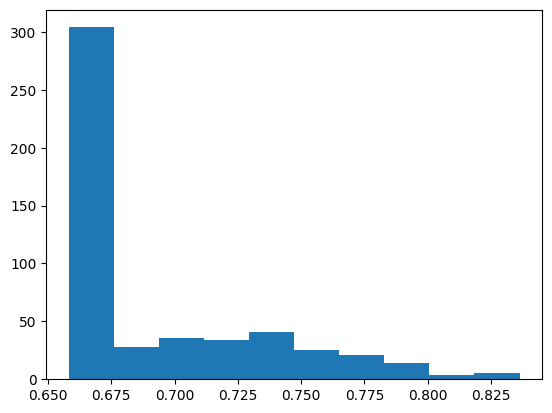

In [92]:
plt.hist(model.hist.hist_edges[:, 5].detach().cpu().numpy())
# model.hist.hist_edges

# run logistic regression on test set

In [ ]:
from tqdm.auto import tqdm

print("Computing distance matrix")
m, n = qf.size(0), gf.size(0)
distmat = np.zeros((m,n))

for iq, q in tqdm(enumerate(qf)):
    dif = abs(gf - q)
    sim = clf.predict_proba(dif)[:, 1]
    distmat[iq, :] =  -sim


# distmat = distmat.numpy()
print(distmat.shape)

print("Computing CMC and mAP")
cmc, mAP = evaluate(distmat, q_pids, g_pids, q_camids, g_camids)

print("Results ----------")
print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
print("------------------")

# compute hist distance

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

def hist_intersection(hist_1, hist_2):
    if hist_1.ndim == 1:
        hist_1 = hist_1.view(1, hist_1.shape[0])
    if hist_2.ndim == 1:
        hist_2 = hist_2.view(1, hist_2.shape[0])
        
    minima = torch.minimum(hist_1, hist_2)
    intersection = torch.true_divide(torch.sum(minima, dim=1), torch.sum(torch.maximum(hist_1, hist_2), dim=1))
    return intersection

In [ ]:
print("Computing distance matrix")
m, n = qf.size(0), gf.size(0)
distmat = np.zeros((m,n))

for iq, q in tqdm(enumerate(qf)):
    for ig, g in enumerate(gf[iq:]):
        d = hist_intersection(q, g)
        distmat[iq, ig] = d
        distmat[ig, iq] = d

In [ ]:
v1 = torch.FloatTensor([[1,10,1,1,1,1,1,1]])
v2 = torch.FloatTensor([[1,4,1,1,1,1,1,1]])
# v2 = v2.repeat(len(v1), 1)

print(hist_intersection(v1, v2))
# print(hist_intersection(v2, v1))
torch.nn.CosineSimilarity()(v1, v2)

# 

In [ ]:
import numpy as np
conf.use_linear_to_get_important_features = False
conf.print_model_parameters_trainable = False
conf.use_linear_to_merge_features = False
conf.use_hist = True
conf.centers = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
conf.widths = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
conf.init_hist("HistYusufLayer")
args.pretrain = 'logs/row53/best_model.pth.tar'
conf.print_model_layers = False

print("Initializing model: {}".format(args.arch))
seed_everythings()
model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model = model.to(device)
model = model.eval()
modify_model(model, args, conf)
print('model loaded ...')

qf1, q_pids1, q_camids1, gf1, g_pids1, g_camids1 = extract_test_feature(model, queryloader, galleryloader, use_bn=False)

In [ ]:
from tqdm.auto import tqdm
print("Computing distance matrix")
m, n = qf1.size(0), gf1.size(0)
distmat = np.zeros((m,n))

for iq, q in tqdm(enumerate(qf1)):
    q_repeat = q.repeat(len(gf1), 1)
    d = 1 - hist_intersection(q_repeat, gf1)
    distmat[iq, :] = d
    

print("Computing CMC and mAP")
cmc, mAP = evaluate(distmat, q_pids, g_pids, q_camids, g_camids)
print("Results ----------")
print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
print("------------------")

In [ ]:
%%time
import numpy as np
conf.use_linear_to_get_important_features = False
conf.print_model_parameters_trainable = False
conf.use_linear_to_merge_features = False
conf.use_hist = True
#conf.centers = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
conf.centers = [0.5, 1.25, 1.75,  2.2, 2.6, 3.0]
#conf.widths = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
conf.widths = [0.5, 0.25, 0.25, 0.2, 0.2, 0.2]
conf.init_hist("HistYusufLayer")
args.pretrain = 'logs/row53/best_model.pth.tar'
conf.print_model_layers = False

print("Initializing model: {}".format(args.arch))
seed_everythings()
model = models.init_model(name=args.arch, conf=conf, num_classes=dataset.num_train_pids)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))
model = model.to(device)
model = model.eval()
modify_model(model, args, conf)
print('model loaded ...')

qf1, q_pids1, q_camids1, gf1, g_pids1, g_camids1 = extract_test_feature(model, queryloader, galleryloader, use_bn=False)

from tqdm.auto import tqdm
print("Computing distance matrix")
m, n = qf1.size(0), gf1.size(0)
distmat = np.zeros((m,n))

for iq, q in tqdm(enumerate(qf1)):
    q_repeat = q.repeat(len(gf1), 1)
    d = 1 - hist_intersection(q_repeat, gf1)
    distmat[iq, :] = d
    

print("Computing CMC and mAP")
cmc, mAP = evaluate(distmat, q_pids1, g_pids1, q_camids1, g_camids1)
print("Results ----------")
print('top1:{:.1%} top5:{:.1%} top10:{:.1%} mAP:{:.1%}'.format(cmc[0],cmc[4],cmc[9],mAP))
print("------------------")